In [2]:
!pip install segmentation-models

     |████████████████████████████████| 50 kB 5.2 MB/s 


In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms
from skimage import io, transform
import segmentation_models as sm
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import torchvision
import torch
import cv2
import os

Segmentation Models: using `keras` framework.


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
class Dataset(tf.keras.utils.Sequence):
    
    def __init__(
        self,
        root_path,
        image_files: list,
        mask_files: list,
        num_classes: int,
        image_dim: tuple,
        batch_size: int
    ) -> None:

        self.root_path = root_path
        self.image_files = image_files
        self.mask_files = mask_files
        self.num_classes = num_classes
        self.image_dim = image_dim
        self.batch_size = batch_size
    
    def __getitem__(self, index: int):
        
        image_paths = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
        images = np.array([
            transform.resize(io.imread(self.root_path + "/images/" + file_name), self.image_dim)
            for file_name in image_paths
        ])
        
        mask_paths = self.mask_files[index * self.batch_size : (index + 1) * self.batch_size]
        masks = np.array([
            transform.resize(io.imread(self.root_path + "/annotations/" + file_name, as_gray=True), self.image_dim, preserve_range=True)
            for file_name in mask_paths
        ])
        
        return images, tf.keras.utils.to_categorical(masks, num_classes=self.num_classes)
    
    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

In [6]:
data_root_path = "./drive/MyDrive/Dataset"
mode = "Train"
root_path = os.path.join(data_root_path, mode)

image_files = list(sorted(os.listdir(os.path.join(root_path, "images"))))
mask_files = list(sorted(os.listdir(os.path.join(root_path, "annotations"))))

train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(image_files, mask_files, test_size=0.20)

train_dataset = Dataset(
    root_path,
    train_image_files,
    train_mask_files,
    num_classes = 12,
    image_dim = (352, 480),
    batch_size = 12,
    transforms=transforms.Compose([
        transforms.RandomAutocontrast(p=0.4),
        transforms.RandomAdjustSharpness(sharpness_factor=1.8, p=0.6),
        transforms.RandomHorizontalFlip(p=0.67),
        transforms.ToTensor(),
    ]),
)

valid_dataset = Dataset(
    root_path,
    val_image_files,
    val_mask_files,
    num_classes = 12,
    image_dim = (352, 480),
    batch_size = 12,
    transforms=transforms.Compose([
        transforms.RandomAutocontrast(p=0.4),
        transforms.RandomAdjustSharpness(sharpness_factor=1.8, p=0.6),
        transforms.RandomHorizontalFlip(p=0.67),
        transforms.ToTensor(),
    ]),
)

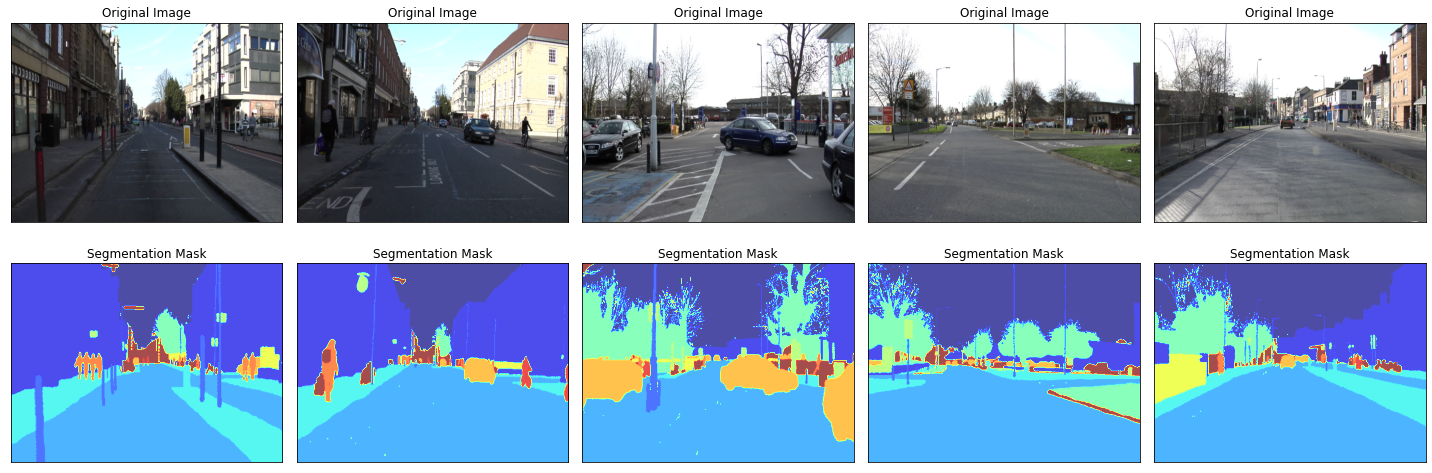

In [7]:
dataset = train_dataset[0]

figure = plt.figure(figsize=(20,7))
indices = [0, 3, 9, 5, 11]
rows, cols = 2, 5

for index in range(5):
    
    figure.add_subplot(rows, cols, index+1)
    plt.title("Original Image")
    plt.imshow(dataset[0][indices[index]])
    plt.xticks([])
    plt.yticks([])

for index in range(5):
    
    figure.add_subplot(rows, cols, index+6)
    plt.title("Segmentation Mask")
    plt.imshow(np.argmax(dataset[1][indices[index]], axis=2), cmap="jet", alpha=0.7)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

**U-Net with VGG19 Backbone:**

In [73]:
tf.keras.backend.set_image_data_format("channels_last")
sm.set_framework('tf.keras')
sm.framework()

model = sm.Unet(
    "vgg19", 
    input_shape=(352, 480, 3), 
    classes=12, 
    activation="softmax", 
    encoder_weights="imagenet",  
    decoder_use_batchnorm=True
)

In [74]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 352, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 352, 480, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 352, 480, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [43]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.005, 
        beta_1=0.9, 
        beta_2=0.999, 
        epsilon=1e-07, 
        amsgrad=True
    ),
    loss=sm.losses.cce_jaccard_loss,
    metrics=["accuracy", sm.metrics.f1_score, sm.metrics.iou_score]
)

callbacks = [ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)]

results = model.fit(
    train_dataset,
    verbose = 1, 
    epochs = 20, 
    callbacks = callbacks,
    validation_data = valid_dataset
)

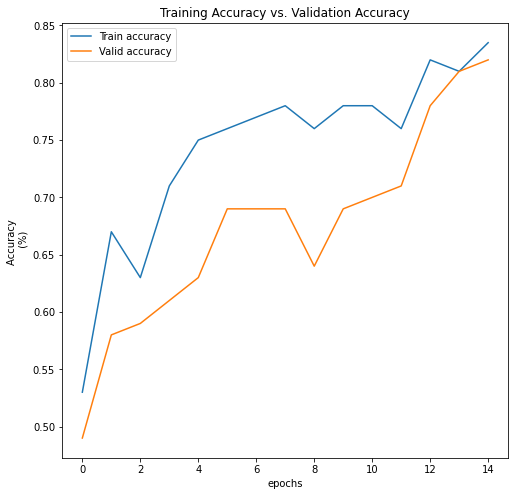

In [49]:
plt.figure(figsize=(8, 8))
plt.title("Training Accuracy vs. Validation Accuracy")
plt.plot(accuracy[:,0], label="Train accuracy")
plt.plot(accuracy[:,1], label="Valid accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy \n (%)")
plt.legend();
plt.show()

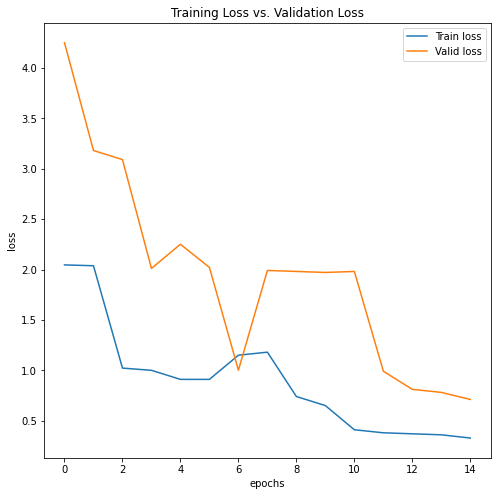

In [56]:
plt.figure(figsize=(8, 8))
plt.title("Training Loss vs. Validation Loss")
plt.plot(results.history["loss"], label="Train loss")
plt.plot(results.history["val_loss"], label="Valid loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend();
plt.show()

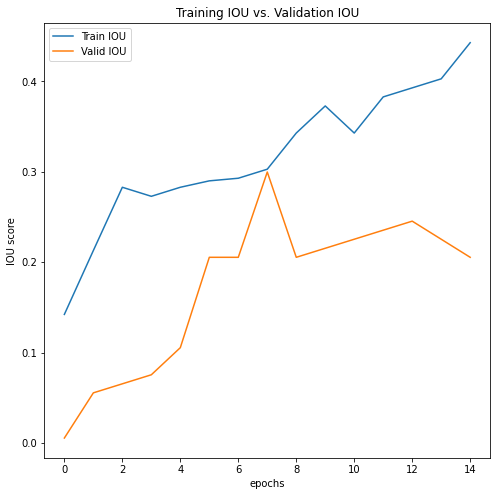

In [59]:
plt.figure(figsize=(8, 8))
plt.title("Training IOU vs. Validation IOU")
plt.plot(results.history["iou_score"], label="Train IOU")
plt.plot(results.history["val_iou_score"], label="Valid IOU")
plt.xlabel("epochs")
plt.ylabel("IOU score")
plt.legend();
plt.show()

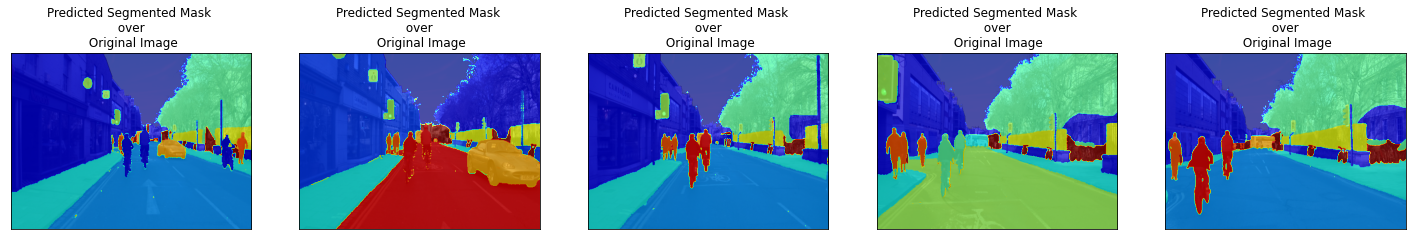

In [63]:
dataset = test_dataset[0]

figure = plt.figure(figsize=(20,7))
indices = [0, 3, 9, 5, 11]
rows, cols = 2, 5

for index in range(5):
    
    figure.add_subplot(rows, cols, index+1)
    plt.title("Predicted Segmented Mask \n over \n Original Image")
    plt.imshow(dataset[0][indices[index]])
    plt.imshow(np.argmax(predictions[indices[index]], axis=2), cmap="jet", alpha=0.7)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

**U-Net with RESNET34 Backbone:**

In [71]:
tf.keras.backend.set_image_data_format("channels_last")
sm.set_framework('tf.keras')
sm.framework()

model = sm.Unet(
    "resnet34", 
    input_shape=(352, 480, 3), 
    classes=12, 
    activation="softmax", 
    encoder_weights="imagenet",  
    decoder_use_batchnorm=True
)

In [72]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 352, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 352, 480, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, 358, 486, 3)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.005, 
        beta_1=0.9, 
        beta_2=0.999, 
        epsilon=1e-07, 
        amsgrad=True
    ),
    loss=sm.losses.cce_jaccard_loss,
    metrics=["accuracy", sm.metrics.f1_score, sm.metrics.iou_score]
)

callbacks = [ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)]

results = model.fit(
    train_dataset,
    verbose = 1, 
    epochs = 20, 
    callbacks = callbacks,
    validation_data = valid_dataset
)

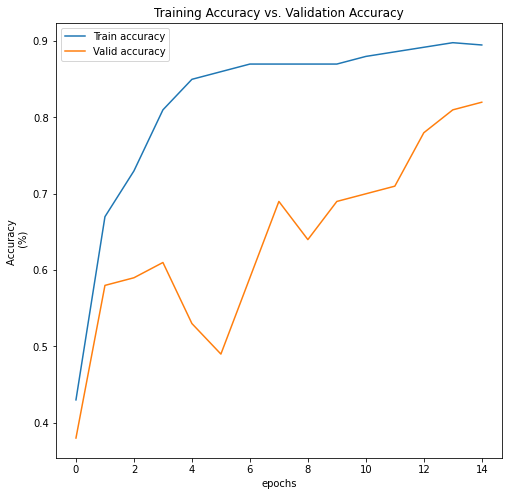

In [13]:
plt.figure(figsize=(8, 8))
plt.title("Training Accuracy vs. Validation Accuracy")
plt.plot(results.history["accuracy"], label="Train accuracy")
plt.plot(results.history["val_accuracy"], label="Valid accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy \n (%)")
plt.legend();
plt.show()

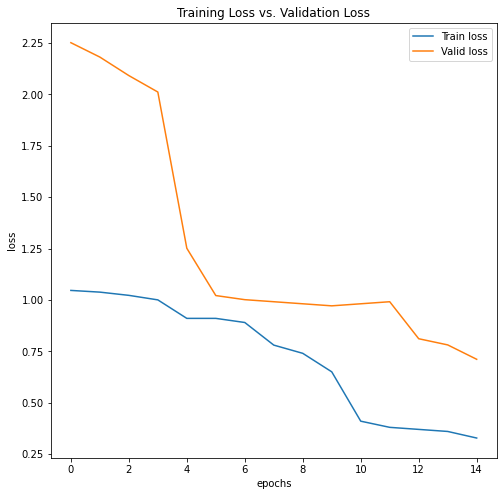

In [18]:
plt.figure(figsize=(8, 8))
plt.title("Training Loss vs. Validation Loss")
plt.plot(results.history["loss"], label="Train loss")
plt.plot(results.history["val_loss"], label="Valid loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend();
plt.show()

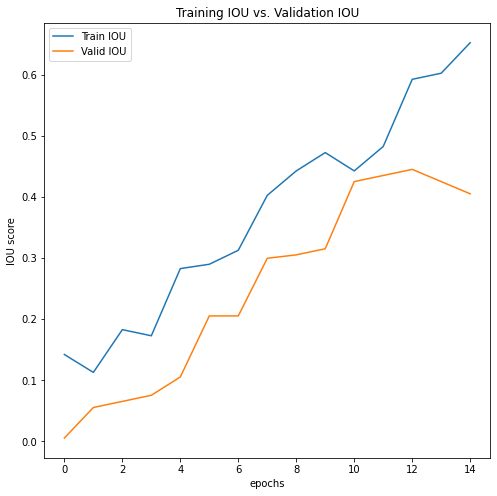

In [62]:
plt.figure(figsize=(8, 8))
plt.title("Training IOU vs. Validation IOU")
plt.plot(results.history["iou_score"], label="Train IOU")
plt.plot(results.history["val_iou_score"], label="Valid IOU")
plt.xlabel("epochs")
plt.ylabel("IOU score")
plt.legend();
plt.show()

In [22]:
data_root_path = "./drive/MyDrive/Dataset"
mode = "Test"
root_path = os.path.join(data_root_path, mode)

image_files = list(sorted(os.listdir(os.path.join(root_path, "images"))))
mask_files = list(sorted(os.listdir(os.path.join(root_path, "annotations"))))

test_dataset = Dataset(
    root_path,
    image_files,
    mask_files,
    num_classes = 12,
    image_dim = (352, 480),
    batch_size = 12
)

predictions = model.predict(test_dataset)

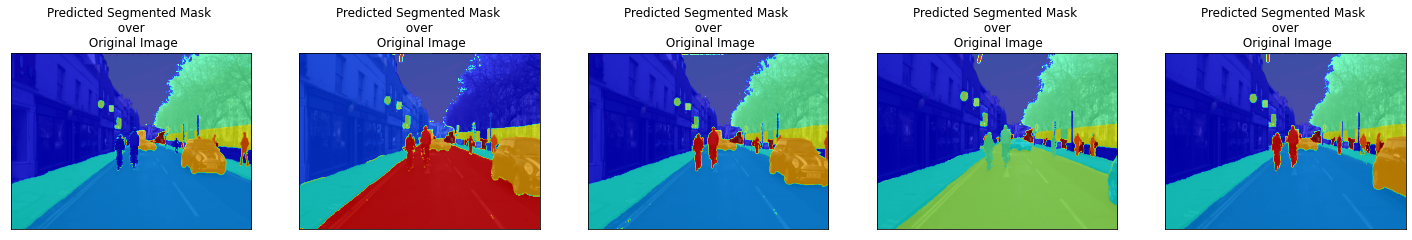

In [40]:
dataset = test_dataset[0]

figure = plt.figure(figsize=(20,7))
indices = [0, 3, 9, 5, 11]
rows, cols = 2, 5

for index in range(5):
    
    figure.add_subplot(rows, cols, index+1)
    plt.title("Predicted Segmented Mask \n over \n Original Image")
    plt.imshow(dataset[0][indices[index]])
    plt.imshow(np.argmax(predictions[indices[index]], axis=2), cmap="jet", alpha=0.7)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()